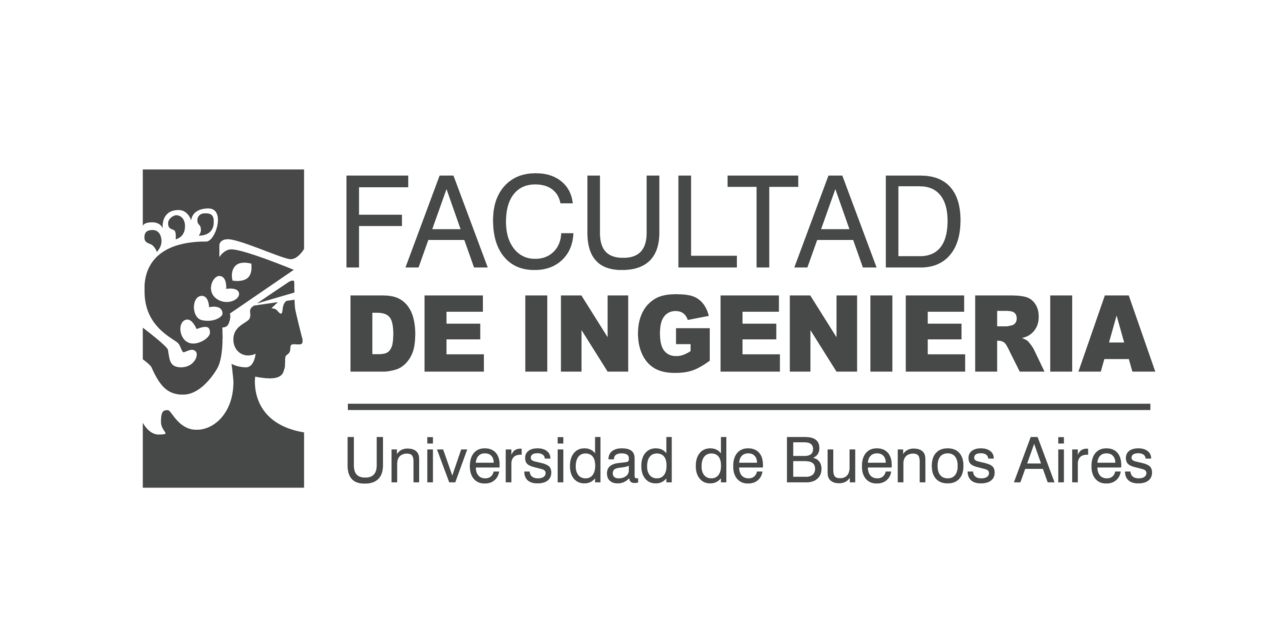

**Profesores:** <br />
Dr. Rodrigo Cardenas Szigety - rodrigo.cardenas.sz@gmail.com <br />
Dr. Nicolás Vattuone - nicolas.vattuone@gmail.com <br />

**Alumno:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-nlp - Ver desafios/Desafio_2.ipynb<br />



### Requisitos y utilidades

In [1]:
%pip install gensim
%pip install tensorflow
%pip install scikit-learn
%pip install plotly
%pip install wordcloud
%pip install matplotlib numpy
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import nltk
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.manifold import TSNE                   
from sklearn.metrics import pairwise
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Descargar las stopwords en caso de que no estén disponibles
nltk.download('stopwords')

2025-05-18 02:49:54.914532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 02:49:55.088330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 02:49:55.223380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747547395.341662    6512 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747547395.377217    6512 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747547395.671997    6512 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

True

### Desafío 2

#### Consigna

1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro 
dataset. 
2. Probar términos de interés y explicar similitudes en el espacio de embeddings. 
3. Intentar plantear y probar tests de analogías. 
4. Graficar los embeddings resultantes.
5. Conclusiones.


Se elige un corpus de mitología y religión que utilizará libros de *gutenberg.org* principalemnte.


| Obra              | Autor              | Link de descarga                                |
|-------------------|--------------------|--------------------------------------------------|
| La Odisea         | Homero             | https://www.gutenberg.org/cache/epub/58221/pg58221.txt |
| La Eneida         | Virgilio           | https://www.gutenberg.org/cache/epub/67197/pg67197.txt |
| La Biblia | Varios autores     | https://github.com/thiagobodruk/bible/blob/master/json/es_rvr.json |

- Convertir todos los textos a `.txt` plano.
- Limpiar (minúsculas, remover puntuación).
- Tokenizar por verso, párrafo o frase.
- Entrenar modelo Word2Vec con `min_count=5`, `window=5`, `vector_size=300`.
- Explorar analogías como:

Algunas posibles relaciones a validar en test de analogías:

- guerra + pecado - cielo ≈ infierno
- hombre - pecado + justicia ≈ equidad

#### Carga y AED

Descargamos todos los corpus y los consolidamos en un unico dataset

In [3]:
# Diccionario de documentos del corpus con sus URLs
textos = {
    "la_odisea.txt": "https://www.gutenberg.org/cache/epub/58221/pg58221.txt",
    "la_eneida.txt": "https://www.gutenberg.org/cache/epub/67197/pg67197.txt",
    "la_biblia.txt": "https://raw.githubusercontent.com/thiagobodruk/bible/refs/heads/master/json/es_rvr.json"
}

In [4]:
def download_corpus(nombre_archivo: str, url: str, type: str = "txt") -> None:
    """
    Descarga un archivo de texto desde una URL y lo guarda localmente.

    Args:
        nombre_archivo (str): Nombre del archivo a guardar.
        url (str): URL del archivo a descargar.
    """
    if type == 'txt':
        print(f"Descargando {nombre_archivo}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(nombre_archivo, "w", encoding="utf-8") as f:
                f.write(response.text)
            print(f"Guardado como {nombre_archivo}")
        else:
            print(f"Error al descargar {url}")
    elif type == 'json':
        print("Descargando la Biblia (JSON)...")
        resp = requests.get(url)
        if resp.status_code == 200:
            biblia_data = json.loads(resp.content.decode("utf-8-sig"))

            with open(nombre_archivo, "w", encoding="utf-8") as f:
                for libro in biblia_data:
                    print(f"Descargando {libro['name']}...")
                    for capitulo in libro["chapters"]:
                        for versiculo in capitulo:
                            f.write(versiculo + "\n")
            print(f"Guardada como {nombre_archivo}")
        else:
            print("No se pudo descargar la Biblia")
            
def build_corpus() -> None:
    """
    Función para construir el corpus a partir de los textos especificados en el diccionario.
    """
    for nombre, url in textos.items():
        if 'biblia' not in nombre:
            download_corpus(nombre, url)
        else:
            download_corpus(nombre, url, type='json')
            
    # Combinar todos los archivos .txt en un único archivo llamado corpus.txt
    with open("corpus.txt", "w", encoding="utf-8") as corpus:
        for nombre in textos.keys():
            if nombre.endswith(".txt"):
                with open(nombre, "r", encoding="utf-8") as f:
                    corpus.write(f.read() + "\n")

In [5]:
build_corpus()

Descargando la_odisea.txt...
Guardado como la_odisea.txt
Descargando la_eneida.txt...
Guardado como la_eneida.txt
Descargando la Biblia (JSON)...
Descargando Genesis...
Descargando Exodus...
Descargando Leviticus...
Descargando Numbers...
Descargando Deuteronomy...
Descargando Joshua...
Descargando Judges...
Descargando Ruth...
Descargando 1 Samuel...
Descargando 2 Samuel...
Descargando 1 Kings...
Descargando 2 Kings...
Descargando 1 Chronicles...
Descargando 2 Chronicles...
Descargando Ezra...
Descargando Nehemiah...
Descargando Esther...
Descargando Job...
Descargando Psalms...
Descargando Proverbs...
Descargando Ecclesiastes...
Descargando Song of Solomon...
Descargando Isaiah...
Descargando Jeremiah...
Descargando Lamentations...
Descargando Ezekiel...
Descargando Daniel...
Descargando Hosea...
Descargando Joel...
Descargando Amos...
Descargando Obadiah...
Descargando Jonah...
Descargando Micah...
Descargando Nahum...
Descargando Habakkuk...
Descargando Zephaniah...
Descargando Hag

In [6]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('corpus.txt', sep='/n', header=None)
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 58220


/tmp/ipykernel_6512/3856363820.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('corpus.txt', sep='/n', header=None)


In [7]:
df.iloc[500:521].head(40)

,0
500,de un varón cuyos blancos huesos se pudren en ...
501,acción de la lluvia ó los revuelven las olas e...
502,"le vieran aportar á Ítaca, preferirían tener l..."
503,ricos de oro y de vestidos. Mas aquél ya murió...
504,"destino, y no hay que esperar en su tornada, a..."
505,hombres terrestres afirme que aún ha de volver...
506,"no amanecerá jamás. Pero, ea, habla y responde..."
507,eres y de qué país procedes? ¿Dónde se hallan ...
508,¿En cuál embarcación llegaste? ¿Cómo los marin...
509,Ítaca? ¿Quiénes se precian de ser? Pues no me ...


In [8]:
def remove_special_characters(text: str) -> str:
    """
    Elimina caracteres especiales y acentos de un texto.

    Args:
        text (str): Texto a limpiar.

    Returns:
        str: Texto limpio.
    """
    reemplazos = {
        r'[áÁ]': 'a',
        r'[éÉ]': 'e',
        r'[íÍ]': 'i',
        r'[óÓ]': 'o',
        r'[úÚ]': 'u',
        r'[ñÑ]': 'n'
    }
    for pattern, replace in reemplazos.items():
        text = re.sub(pattern, replace, text)
    return text

def clean_corpus(df: pd.DataFrame, text_column: str = "texto") -> pd.DataFrame:
    stop_words = set(stopwords.words('spanish'))
    
    # Quito palabras frecuentes, conectores, o exclamaciones que tal vez no tengan
    # mucho sentido en el contexto del analisis semantico a realizar sobre este corpus
    extra_stopwords = {
        "diciendo", "dijo", "asi", "pues", "mas", "ti", "dicho", "la", "asimismo",
        "entonce", "aqui", "oh", "este", "hace", "cada", "aun", "cuanto", 
        "hara", "por", "amen", "ello", "fue", "hacer", "cuales", "hablo", "dijeron", 
        "dice", "despues", "ser", "aquella", "dijole", "segun", "aquello", "oido",
        "dado", "da"
    }
    
    # Normalizar también las stopwords (sin tildes)
    stop_words = {remove_special_characters(w.lower()) for w in stop_words.union(extra_stopwords)}

    def clean_text(text: str) -> str:
        text = text.lower()
        text = remove_special_characters(text)
        text = re.sub(r'[^\w\s]', '', text)     # quitar puntuación
        text = re.sub(r'\s+', ' ', text)        # quitar múltiples espacios
        palabras = text.split()
        palabras_filtradas = [w for w in palabras if w not in stop_words]
        return ' '.join(palabras_filtradas)
    
    df[text_column] = df[text_column].apply(clean_text)
    return df

def word_cloud(df: pd.DataFrame) -> WordCloud:
    """
    Genera un wordcloud a partir de un dataframe.

    Args:
        df (pd.DataFrame): Dataframe que contiene el texto para el wordcloud.

    Returns:
        WordCloud: Instancia de WordCloud generada a partir del texto.
    """
    # Combinar todo el texto del dataframe en una sola cadena
    text = " ".join(df[0].astype(str).tolist())

    # Crear el wordcloud
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)
    
    return wordcloud

df_clean = clean_corpus(df, text_column=0)
df_clean.iloc[500:521].head(40)


,0
500,varon cuyos blancos huesos pudren continente
501,accion lluvia revuelven olas seno mar
502,vieran aportar itaca preferirian tener pies li...
503,ricos oro vestidos aquel murio victima aciago
504,destino esperar tornada aunque alguno
505,hombres terrestres afirme volver dia regreso
506,amanecera jamas ea habla responde sinceramente
507,pais procedes hallan ciudad padres
508,embarcacion llegaste marineros trajeron
509,itaca precian figuro venido


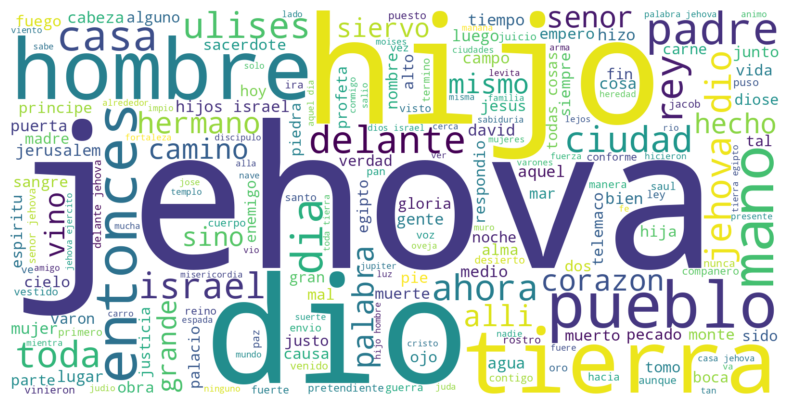

In [9]:
word_cloud_obj = word_cloud(df_clean)

# Mostrar el wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud_obj, interpolation='bilinear')
plt.axis('off')
plt.show()

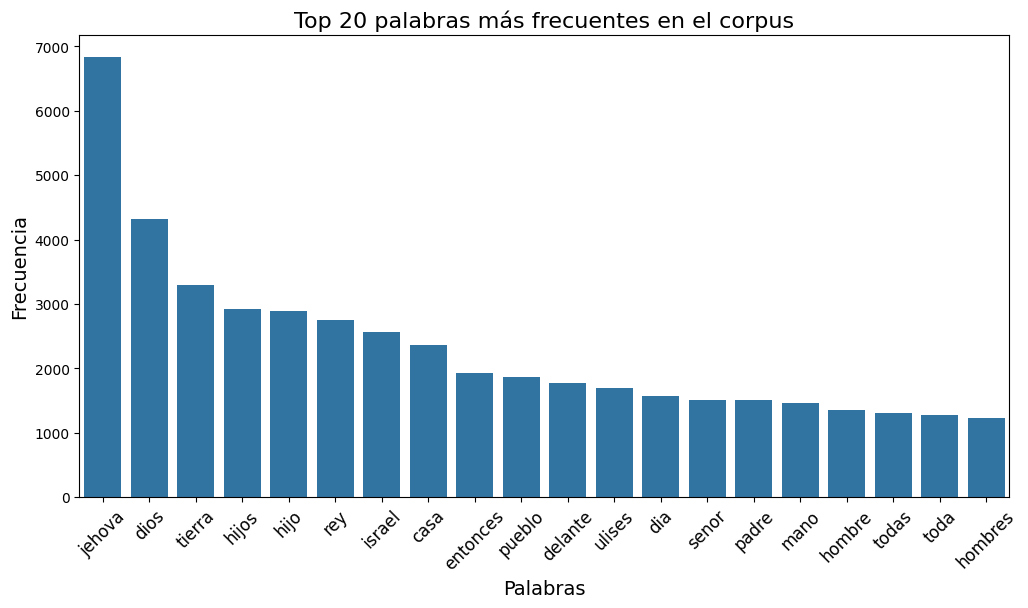

In [10]:
def word_frequency_words(df: pd.DataFrame) -> None:
    """
    Muestra la frecuencia de las palabras en el corpus.
    """
    # Contar la frecuencia de cada palabra en el corpus
    filtered_words = " ".join(df[0].astype(str).tolist()).split()
    word_counts = Counter(filtered_words)

    # Obtener las 20 palabras más frecuentes
    most_common_words = word_counts.most_common(20)

    # Separar las palabras y sus frecuencias para graficar
    words, counts = zip(*most_common_words)

    # Crear el gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.title("Top 20 palabras más frecuentes en el corpus", fontsize=16)
    plt.xlabel("Palabras", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()
    
word_frequency_words(df_clean)

#### 1. Crear vectores con Gensim sobre corpus  

In [11]:
sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [12]:
sentence_tokens[500:505]

[['varon', 'cuyos', 'blancos', 'huesos', 'pudren', 'continente'],
 ['accion', 'lluvia', 'revuelven', 'olas', 'seno', 'mar'],
 ['vieran', 'aportar', 'itaca', 'preferirian', 'tener', 'pies', 'ligeros'],
 ['ricos', 'oro', 'vestidos', 'aquel', 'murio', 'victima', 'aciago'],
 ['destino', 'esperar', 'tornada', 'aunque', 'alguno']]

In [13]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [14]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=5,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=8,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [15]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [16]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de docs en el corpus: 58220
Cantidad de words distintas en el corpus: 11262


In [17]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 716140.4375
Loss after epoch 1: 595070.5625
Loss after epoch 2: 580325.75
Loss after epoch 3: 502688.25
Loss after epoch 4: 502419.5
Loss after epoch 5: 512773.5
Loss after epoch 6: 418058.25
Loss after epoch 7: 457128.25
Loss after epoch 8: 425944.5
Loss after epoch 9: 430870.5
Loss after epoch 10: 403608.0
Loss after epoch 11: 414747.5
Loss after epoch 12: 375625.5
Loss after epoch 13: 357860.5
Loss after epoch 14: 382328.0
Loss after epoch 15: 371754.0
Loss after epoch 16: 430904.5
Loss after epoch 17: 336115.5
Loss after epoch 18: 338580.0
Loss after epoch 19: 313792.0
Loss after epoch 20: 332485.0
Loss after epoch 21: 375367.0
Loss after epoch 22: 307184.0
Loss after epoch 23: 322203.0
Loss after epoch 24: 289161.0
Loss after epoch 25: 312249.0
Loss after epoch 26: 321105.0
Loss after epoch 27: 346068.0
Loss after epoch 28: 300775.0
Loss after epoch 29: 295620.0


(10801551, 12945270)

#### 2. Probar términos de interés y explicar similitudes en el espacio de embeddings. 

Elegimos como palabras relevantes del corpus:
- dios
- tierra
- pueblo
- justicia

Agregamos funciones para plotear matrices de distancia para embeddings de palabras del corpus.

In [18]:

def plot_matrix_distance(words: list, dist: np.ndarray) -> None:
    """
    Muestra la matriz de distancias entre los embeddings de las palabras.

    Args:
        words (list): Lista de palabras para calcular la distancia.
        dist (np.ndarray): Matriz de cosine_similaruty entre los embeddings.
    """
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

def embeddings_matrix_distance(model: Word2Vec, words: list) -> None:
    """
    Muestra la matriz de distancias entre los embeddings de las palabras.

    Args:
        model (Word2Vec): Modelo gensim Word2Vec entrenado.
        words (list): Lista de palabras para calcular la distancia.
    """
    print("Cantidad de palabras:", len(words))
    emb = get_words_embeddings(model, words)
    print("Dimensiones de los embeddings:", emb.shape)
    dist = pairwise.cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)

def get_words_embeddings(model: Word2Vec, words: list) -> np.ndarray:
    """
    Replica comportamiento de FastEmbeddings model.get_words_embeddings(words)
    
    Args:
        model: Modelo gensim Word2Vec entrenado
        words: Lista de strings (words)

    Returns:
        numpy.ndarray con shape (len(words), vector_size)
        Palabras no enontradas en vocabulario retornan zero vector.
    """
    vector_size = model.vector_size
    embeddings = []
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            embeddings.append(np.zeros(vector_size))  # si no esta en vocab 0's
    return np.vstack(embeddings)


In [19]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["dios"], topn=10)

[('jehova', 0.5147119164466858),
 ('formador', 0.4951378107070923),
 ('sirvais', 0.4745767116546631),
 ('redimio', 0.4575314521789551),
 ('eternidad', 0.45581480860710144),
 ('concerto', 0.4548649787902832),
 ('desamparara', 0.44453778862953186),
 ('temereis', 0.4423023760318756),
 ('celebrad', 0.43995484709739685),
 ('miento', 0.4395443797111511)]

Se observan acciones y adjetivos y palabras en general con similitud semántica en estos corpus específicos para la palabra dios como sirvais, formador, eternidad.

Cantidad de palabras: 11
Dimensiones de los embeddings: (11, 300)


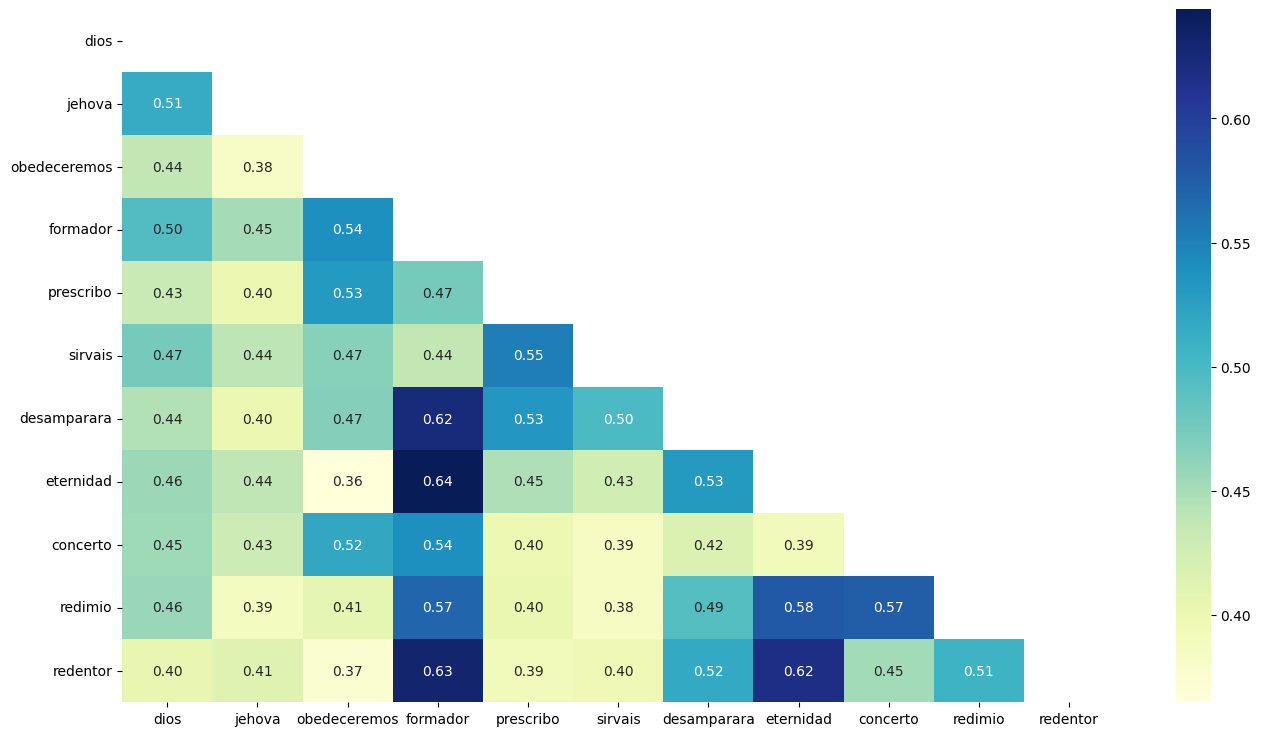

In [20]:
words = [
    "dios", "jehova", "obedeceremos", "formador", "prescribo", 
    "sirvais", "desamparara", "eternidad", "concerto", "redimio",
    "redentor"
]

embeddings_matrix_distance(w2v_model, words)

In [21]:
w2v_model.wv.most_similar(positive=["tierra"], topn=10)

[('canaan', 0.49434131383895874),
 ('airo', 0.45678526163101196),
 ('poseerla', 0.44611823558807373),
 ('entrais', 0.44531363248825073),
 ('entras', 0.4326740503311157),
 ('ur', 0.43028903007507324),
 ('vertientes', 0.4277143180370331),
 ('especies', 0.42476579546928406),
 ('fluye', 0.4207461178302765),
 ('segareis', 0.4188137948513031)]

Cantidad de palabras: 11
Dimensiones de los embeddings: (11, 300)


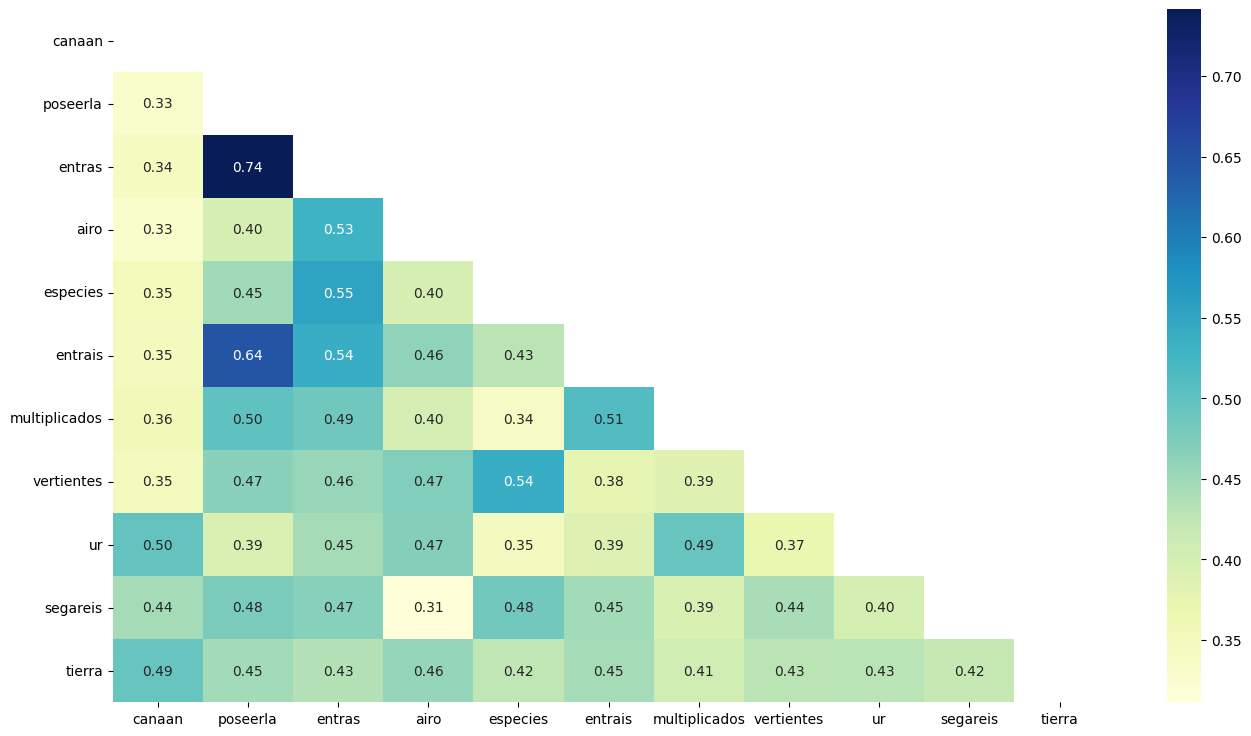

In [22]:
words = [
    "canaan", "poseerla", "entras", "airo", "especies", 
    "entrais", "multiplicados", "vertientes", "ur", "segareis",
    "tierra"
]

embeddings_matrix_distance(w2v_model, words)

In [23]:
w2v_model.wv.most_similar(positive=["pueblo"], topn=10)

[('israel', 0.39852583408355713),
 ('jehova', 0.3777998685836792),
 ('echarlo', 0.36871659755706787),
 ('jethro', 0.36731839179992676),
 ('convoco', 0.35928991436958313),
 ('desamparare', 0.3560103178024292),
 ('ofrecieren', 0.3532659113407135),
 ('santificaos', 0.34827566146850586),
 ('orare', 0.3479142487049103),
 ('profetizaron', 0.34646230936050415)]

Cantidad de palabras: 11
Dimensiones de los embeddings: (11, 300)


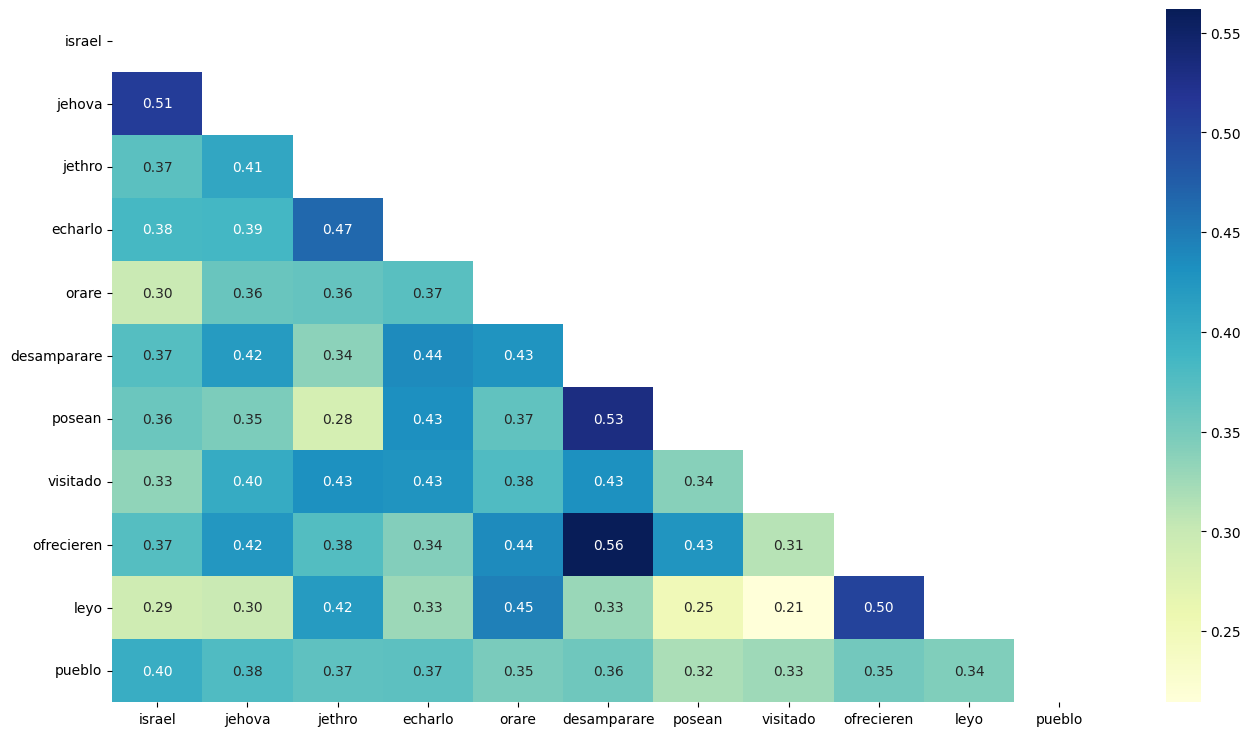

In [24]:
words = [
    "israel", "jehova", "jethro", "echarlo", "orare", 
    "desamparare", "posean", "visitado", "ofrecieren", "leyo",
    "pueblo"
]

embeddings_matrix_distance(w2v_model, words)

In [25]:
w2v_model.wv.most_similar(positive=["justicia"], topn=10)

[('equidad', 0.45578691363334656),
 ('impiedad', 0.4469141960144043),
 ('rectitud', 0.4295465052127838),
 ('entras', 0.4128029942512512),
 ('justifica', 0.3988371789455414),
 ('selah', 0.38654738664627075),
 ('sustenta', 0.3790278434753418),
 ('elegi', 0.3721773624420166),
 ('juzgais', 0.36601346731185913),
 ('juzgara', 0.36222460865974426)]

Cantidad de palabras: 11
Dimensiones de los embeddings: (11, 300)


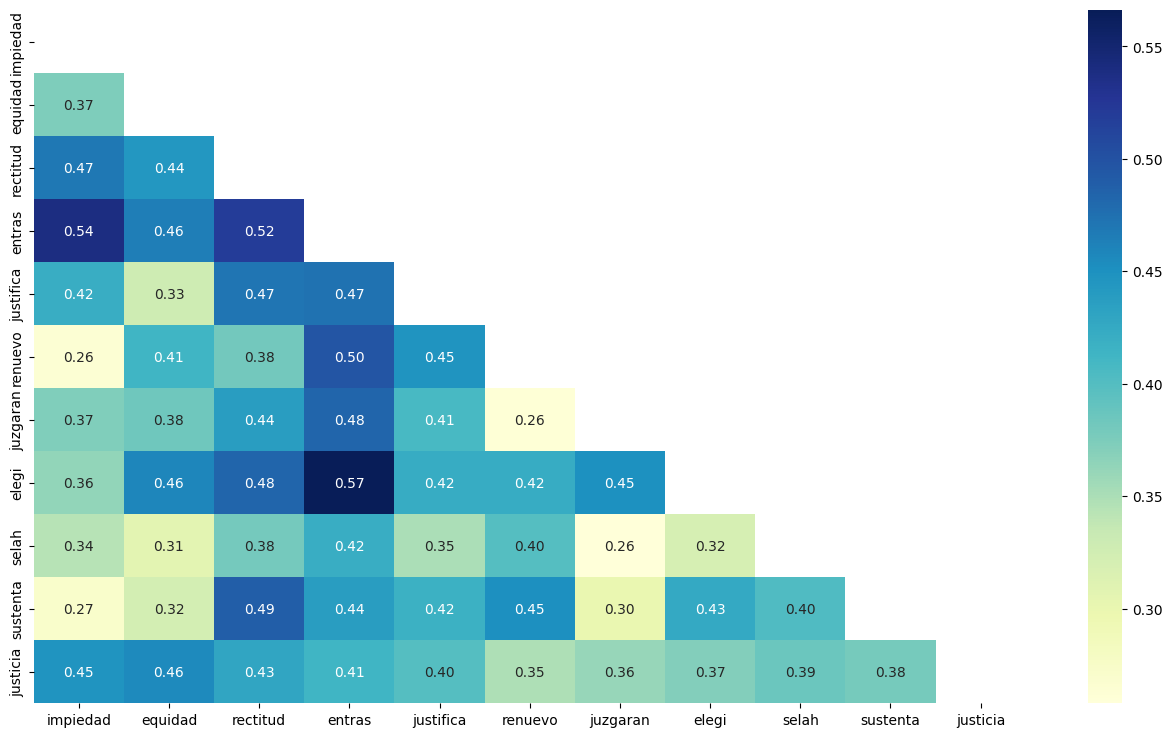

In [26]:
words = [
    "impiedad", "equidad", "rectitud", "entras", "justifica", 
    "renuevo", "juzgaran", "elegi", "selah", "sustenta",
    "justicia"
]

embeddings_matrix_distance(w2v_model, words)

Al igual que con *dios*, para *tierra*, *justicia* y *pueblo* tenemos mapeado en el espacio de embeddings como palabras mas cercanas otras con similitud semántica como en el caso de *justicia* que tenemos rectitud, equidad, juzgaran. En el caso de sufrimos tiene especial sentido en textos como la biblia en relacion a justicia.

#### 3. Intentar plantear y probar tests de analogías. 

- guerra + pecado - cielo ≈ infierno
- hombre - pecado + justicia ≈ equidad

In [27]:
# probamos un test de analogía
test_words = ['rey', 'hombre', 'mujer', 'pecado', 'dios', 'reina',
              'tierra', 'desierto', 'guerra', 'cielo', 'infierno', 'justicia', 'justo']
test_emb = get_words_embeddings(w2v_model, test_words)

# guerra + pecado - cielo = infierno
nuevo_infierno = test_emb[8] + test_emb[3] - test_emb[9]

# hombre - pecado + justicia = equidad
nueva_equidad = test_emb[1] - test_emb[3] + test_emb[11]

In [31]:
similar_words = w2v_model.wv.similar_by_vector(nueva_equidad, topn=10)
for i in similar_words:
    print(i)

('justicia', 0.6481355428695679)
('hombre', 0.5146399140357971)
('asirio', 0.2576836943626404)
('equidad', 0.2566772401332855)
('brota', 0.2538529932498932)
('loor', 0.25226616859436035)
('fia', 0.2515580952167511)
('entras', 0.24505314230918884)
('habitareis', 0.24395467340946198)
('ensalza', 0.24221648275852203)


In [29]:
similar_words = w2v_model.wv.similar_by_vector(nuevo_infierno, topn=10)
for i in similar_words:
    print(i)

('pecado', 0.6217236518859863)
('guerra', 0.6117261648178101)
('pelear', 0.3217189311981201)
('jornada', 0.314810186624527)
('perdonado', 0.3112878203392029)
('guardado', 0.30843207240104675)
('iniquidad', 0.3075152337551117)
('yerro', 0.2978801131248474)
('rebelado', 0.29455894231796265)
('prevaricacion', 0.29185575246810913)


Vemos que nueva equidad aparece entre las primeras palabras similares. En el caso de nuevo_infierno esto no sucede pero muchas de las similares tienen una connotacion negativa como *pelear* por lo que se entiende se mapea con palabras de connotacion negativa como se esperaba. No obstante las cercanias no parecen "fuertes" por lo que se entiende que el corpus es aun pequeño, o bien no se ha capturado mucho de la semantica de las palabras por otros motivos.

#### 4. Graficar los embeddings resultantes.

In [30]:
def reduce_dimensions(model: Word2Vec, num_dimensions: int = 2) -> tuple:
    """
    Reduce la dimensionalidad de los vectores de palabras utilizando t-SNE.

    Args:
        model (Word2Vec): Modelo gensim Word2Vec entrenado.
        num_dimensions (int, optional): Número de dimensiones. Defaults to 2.

    Returns:
        tuple: Vectores reducidos y etiquetas de palabras.
    """
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [32]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en cola

![embeddings](img/embeddings.png)

#### 5. Conclusiones

Se implementó un pipeline de procesamiento de texto aplicado a un corpus conformado por La Biblia, La Eneida y La Ilíada. El objetivo fue generar representaciones semánticas de palabras utilizando el modelo Word2Vec.

Se realizaron tareas de limpieza y normalización del texto, incluyendo la eliminación de stopwords tradicionales y una lista extendida adaptada al lenguaje narrativo específico de las obras analizadas. Esta etapa se agregó con la idea de reducir el ruido y mejorar la calidad de los vectores generados.

El modelo se entrenó con Skip-Gram, una ventana contextual de tamaño 5, dimensionalidad de embeddings de 300 y min_count=5 durante 30 épocas. Estos hiperparámetros permitieron capturar algo de las relaciones semánticas existentes, especialmente entre nombres propios, lugares y atributos divinos particulares del corpus utilizado.

En resumen, se logró construir un modelo capaz de reflejar parte de la estructura semántica subyacente en estos textos donde se entiende que aún hay mucho espacio para mejora.

![Image 1](img/1.png)

![Image 2](img/2.png)

![Image 3](img/3.png)

![Image 4](img/4.png)
